<a href="https://colab.research.google.com/github/crinex/What-is-CNN/blob/main/CNN(CIFAR10).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CNN을 이용해 개와 고양이를 구분하는 프로그램을 만들어보자

### CIFAR10 데이터에서 개와 고양이 데이터를 사용하자

In [ ]:
from keras.datasets import cifar10

In [ ]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
import numpy as np
import pandas as pd

CAT_VALUE = 3
DOG_VALUE = 5

condition_train = (train_labels[:,0]==CAT_VALUE) | (train_labels[:,0]==DOG_VALUE)
condition_test = (test_labels[:,0]==CAT_VALUE) | (test_labels[:,0]==DOG_VALUE)

x_train = train_images[condition_train]
y_train = train_labels[condition_train]
x_test = test_images[condition_test]
y_test = test_labels[condition_test]

print('x_train shape is ', x_train.shape)
print('y train shape is ', y_train.shape)
print('x test shape is ', x_test.shape)
print('y test shape is ', y_test.shape)

x_train shape is  (10000, 32, 32, 3)
y train shape is  (10000, 1)
x test shape is  (2000, 32, 32, 3)
y test shape is  (2000, 1)


## Data Analysis
- x_train : 32x32x3(RGB), 10000개의 훈련을 위한 데이터 
- y_train : 10000개의 이미지를 고양이(3), 강아지(5)의 두가지의 정수로 라벨링

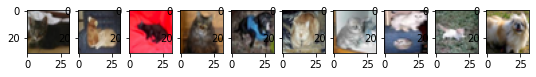

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 90))
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.imshow(x_train[i])

plt.show()

In [ ]:
y_train[:10]

array([[3],
       [3],
       [3],
       [3],
       [5],
       [3],
       [3],
       [3],
       [3],
       [5]], dtype=uint8)

### Edge Detection
- 이미지의 특징을 추출하기 위해 컨벌루션이라는 기법을 사용한다.
- 컨벌루션은 이미지에 3x3이나 5x5 필터를 오른쪽과 아래로 이동하며 적용시키는 기술이다.
- 필터에 들어가는 값에 따라서 다양한 이미지의 특징들을 보여준다
- sobel_h와 sobel_v 필터링을 적용시켜보자

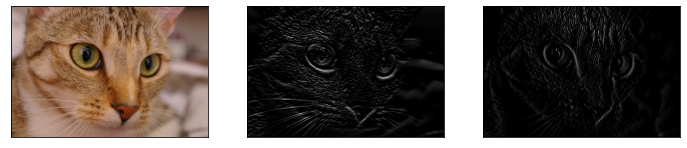

In [ ]:
from skimage.data import chelsea
from skimage.filters import sobel_h, sobel_v
from skimage.color import rgb2gray

# INPUT
image = chelsea()
grey_image = rgb2gray(image)

# CONV
edge_h = sobel_h(grey_image)
edge_v = sobel_v(grey_image)

# ReLU
edge_h = np.where(edge_h < 0, 0, edge_h)
edge_v = np.where(edge_v < 0, 0, edge_v)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,2)
plt.imshow(edge_h, cmap=plt.cm.gray)
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,3)
plt.imshow(edge_v, cmap=plt.cm.gray)
plt.xticks([])
plt.yticks([])
plt.show()

- 왼쪽은 원본 이미지, 가운데는 가로 경계선이 강조되는 sobel_h, 오른쪽은 세로선이 강조되는 sobel_v를 필터링한 이미지다.

### CNN의 핵심 아이디어
- 네트워크에 여러개의 필터를 준비하고 필터에 들어가는 값을 w로 놓으면 학습하면서 다른 사물과 구분되는 해당 이미지만의 특징을 나타내는 필터 값들을 스스로 필터링 하지 않을까

## CNN Modeling
### Convolution Layer
- 이미지에 Convolutoin을 수행하는 레이어다.
- 필터의 개수, 필터의 크기, 패딩 방법을 정의한다.
- 예를 들어 (32, 32, 3) 이미지에 (3, 3)필터 64개를 적용하면 (30, 30, 64)의 이미지가 출력된다.
- 입력 이미지와 출력 이미지의 해상도가 달라지는것을 방지 하기 위해 패딩을 입력 이미지에 적용한다.

### Filter
- 일반적으로 3x3, 5x5필터를 사용한다.
- 보통 필터의 개수는 레이어가 추가될 때마다 두배로 늘린다.

### Padding
- 입력 이미지 메트릭스를 상하, 좌우로 '0'을 추가하는것을 패딩이라 한다.
- f를 필터 사이즈라 하고 p를 패딩 사이즈라 하면 입력 이미지와 출력 이미지의 해상도를 같게 해 주기 위해서는 p = f-1/2 로 한다.
- 예를 들어 (32, 32, 3)이미지에 (3, 3)필터 64개를 적용하고 패딩을 1로 하면 (32, 32, 64)의 이미지가 출력된다.

### Activation Layer
- 0보다 작은 값은 0으로 만들어 사물의 경계선만을 특징으로 선택한다. 
- 따라서 렐루를 사용한다.

### Pooling Layer
- 보통 레이어가 추가될 때 마다 필터 개수는 두배로 늘리고 해상도는 반으로 줄이도록 설계한다. 
- 사물의 특징을 보존하면서 해상도를 줄이는 역할을 수행한다.
- MaxPooling은 필터값이 없는 윈도우가 이미지 위에서 이동하면서 내부의 값들 중에 최댓값을 선택하는 방식이다.
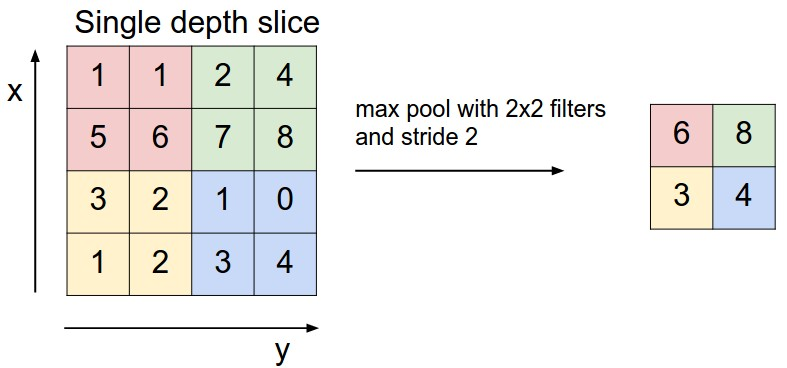


### Dropout
- Overfitting을 방지하기 위한 방법으로서 주어진 확률로 랜덤하게 유닛을 선택해서 꺼버린다.
- 예를 들어 레이어의 유닛수가 32개이고 Dropout확률이 0.25면 입력이 들어올 때마다 8개의 유닛을 랜덤하게 꺼버린다.
- 훈련 과정에서만 적용한다.

### FC Layer
- 히든 레이어로서 모든 유닛이 빠짐없이 연결되어 있다.
- Dense를 의미

### Output Layer
- 고양이냐 강아지냐 0과 1의 문제이므로 Sigmoid를 사용한다.

## 정리
1. CONV = 3x3 filter, padding='same', activatoin='relu'
2. [CONV 32]x2 : 32개의 필터로 CONV를 두번 수행한다.
3. POOL = 2x2 window, dropout = 0.25로 정의한다.
4. [POOL] : Pool을 수행한다. 1/4 확률로 랜덤하게 유닛을 꺼버린다.
5. [CONV 64]x2 : 64개의 필터로 CONV를 두번 수행한다. 
6. [POOL] : Pool을 수행한다. 1/4 확률로 랜덤하게 유닛을 꺼버린다.
7. FC = activation = 'relu', 3. dropout = 0.25로 정의한다.
8. [FC 512] : 512개의 유닛으로 네트워크 레이어를 정의한다. 1/4 확률로 랜덤하게 유닛을 꺼버린다.
9. [OUTPUT] : Sigmoid로 출력 레이어를 정의한다.

In [ ]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

### 이진 분류
- 고양이냐 강아지냐 문제이기 때문에 0과 1로 변환시켜준다. 
- 활성화 함수는 시그모이드를 사용한다.

In [ ]:
y_train = np.where(y_train==3, 0, 1)
y_test = np.where(y_test==3, 0, 1)

## Modeling

In [ ]:
from keras import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

import os

In [ ]:
save_dir = os.getcwd()
model_name = 'keras_catdog_trained_model.h5'

batch_size = 32
epochs = 100

model = Sequential()
# CONV 32x32
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))

# POOL
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# CONV 64x2
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
# POOL
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Vectorization
model.add(Flatten())
# FC 512
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.25))
# OUTPUT
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
hist = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              shuffle=True,
              verbose=0)

# Save model and weights
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

train_acc = hist.history['accuracy'][-1]
train_loss =  hist.history['loss'][-1]

print('train accuracy: ', train_acc)
print('train loss: ', train_loss)

Saved trained model at /content/keras_catdog_trained_model.h5 


KeyError: ignored

In [ ]:
train_acc = hist.history['accuracy'][-1]
train_loss =  hist.history['loss'][-1]

print('train accuracy: ', train_acc)
print('train loss: ', train_loss)

train accuracy:  0.991100013256073
train loss:  0.0288142878562212


In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)
print('Test ACC : ', test_acc)
print('Test Loss : ', test_loss)

63/63 [==============================] - 2s 28ms/step - loss: 1.1453 - accuracy: 0.7795
Test ACC :  0.7795000076293945
Test Loss :  1.1452730894088745


- 누가봐도 과적합인 상황..
- 훈련 데이터로는 99프로의 정확도를 보이지만 테스트 데이터로는 77프로의 정확도를 보인다.

In [ ]:
import pandas as pd

df = pd.DataFrame(data=[[train_acc, test_acc]],
                  index=['CNN'],
                  columns=['Train Accuracy', 'Test Accuracy'])
df

,Train Accuracy,Test Accuracy
CNN,0.9911,0.7795


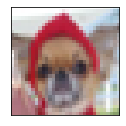

This is a  dog


In [ ]:
from  tensorflow.keras.models import load_model
import os

load_dir = os.getcwd()
model_name = 'keras_catdog_trained_model.h5'
model_path = os.path.join(load_dir, model_name)

pick_image = 30 # 0 ~ 1,999

def predict_catdog(x, model):
    x_data =(np.expand_dims(x, 0))
    predict = model.predict(x_data)
    #print(predict)
    if predict < 0.5:
        return 'cat'
    else:
        return 'dog'

test_data = x_test[pick_image]
model = load_model(model_path)

result = predict_catdog(test_data, model)

plt.figure(figsize=(2,2))
plt.imshow(test_data)
plt.xticks([])
plt.yticks([])
plt.show()
print('This is a ', result)